In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Regler_class_file import P_controller_class
from Regler_class_file import PI_controller_class


In [2]:
# # %matplotlib widget
# pi_controller = PI_controller_class(setpoint=100,proportionality_constant=1,Ti = 30,timestep = 0.1)

# t_max   = 100   #s
# dt      = 0.1   #s
# nt = int(t_max//dt)
# t_vec = np.arange(0,nt+1,1)*dt

# PV_0 = 50

# PV_vec = np.full_like(t_vec,PV_0)

# for i in range(1,nt+1):
#     pi_controller.calculate_error(PV_vec[i-1])

#     if i == 500:
#         pi_controller.SP = 0.
#     PV_vec[i] = PV_vec[i-1]+pi_controller.get_control_variable()



# plt.plot(t_vec,PV_vec,'.')

In [3]:
SP_0 = 1.1
SP_1 = 0.24
PV_0 = 0.5

In [4]:
n = 10
Kp_max = 5.
Ti_max = 5.
d_Kp = Kp_max/n
d_Ti = Ti_max/n
kp_vec = np.arange(1,n+1,1)*d_Kp
Ti_vec = np.arange(1,n+1,1)*d_Ti

XX,YY = np.meshgrid(kp_vec,Ti_vec)

ise_mat = np.empty_like(XX)
iae_mat = np.empty_like(XX)
itse_mat = np.empty_like(XX)
itae_mat = np.empty_like(XX)


t_max   = 100   #s
dt      = 0.05   #s
nt = int(t_max//dt)
t_vec = np.arange(0,nt+1,1)*dt

for i in range(n):
    if i%10 == 0:
        print(i)
    for j in range(n):
        Kp = XX[i,j]
        Ti = YY[i,j]

        c = PI_controller_class(SP_0,Kp,Ti,dt)

        PV_vec = np.full_like(t_vec,PV_0)

        for t in range(1,nt+1):
            c.calculate_error(PV_vec[t-1])

            if t == 500:
                c.SP = SP_1
            PV_vec[t] = PV_vec[t-1]+c.get_control_variable()
        
        ise_mat[i,j],iae_mat[i,j],itse_mat[i,j],itae_mat[i,j] = np.log(c.get_performance_indicators())




0


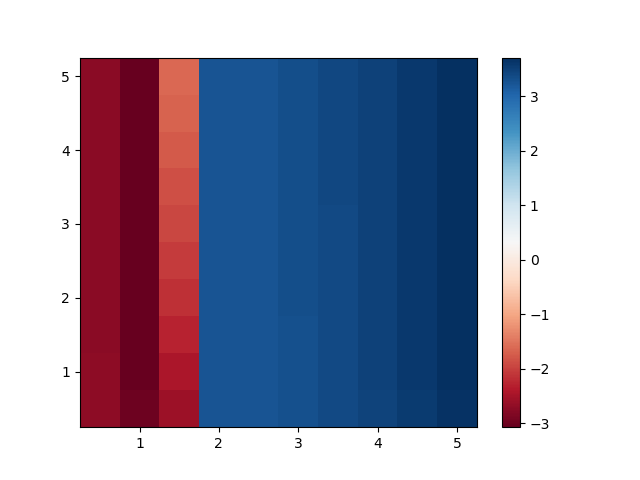

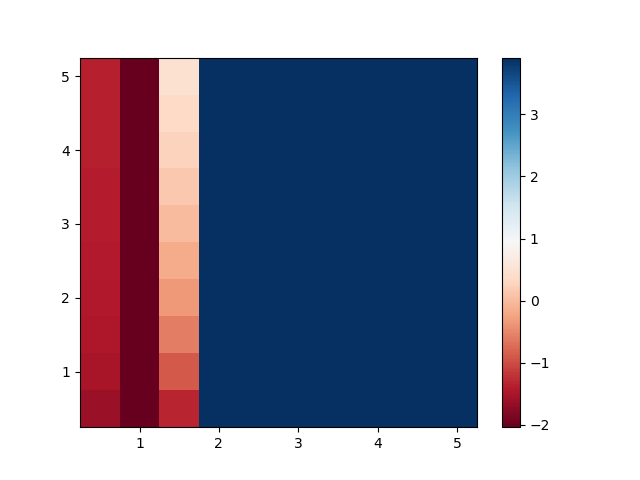

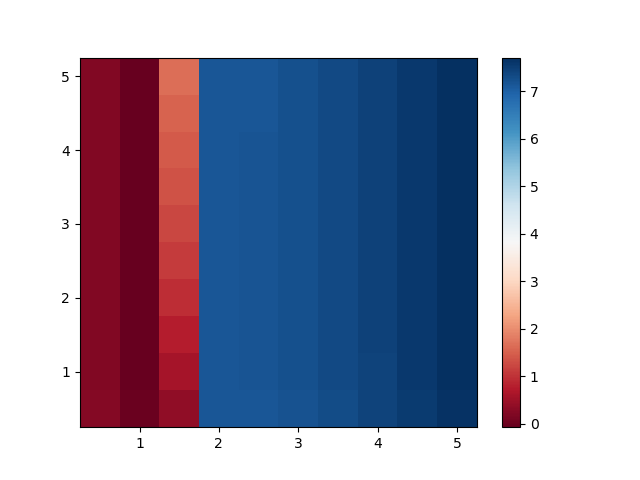

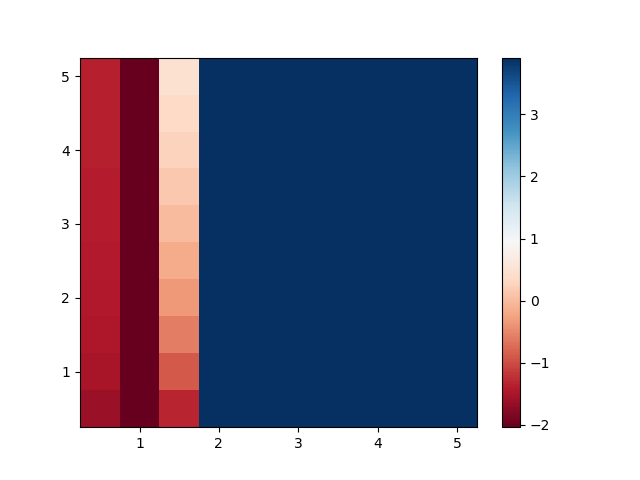

In [5]:
%matplotlib widget
fig1,axs1 = plt.subplots(1,1)
ise_min = np.min(ise_mat)
ise_max = np.max(ise_mat)
mesh1 = axs1.pcolormesh(XX,YY,ise_mat,cmap='RdBu', vmin=ise_min, vmax=ise_max,shading='nearest')
fig1.colorbar(mesh1)
fig2,axs2 = plt.subplots(1,1)
iae_min = np.min(iae_mat)
iae_max = np.max(iae_mat)
mesh2 = axs2.pcolormesh(XX,YY,iae_mat,cmap='RdBu', vmin=iae_min, vmax=iae_max,shading='nearest')
fig2.colorbar(mesh2)
fig3,axs3 = plt.subplots(1,1)
itse_min = np.min(itse_mat)
itse_max = np.max(itse_mat)
mesh3 = axs3.pcolormesh(XX,YY,itse_mat,cmap='RdBu', vmin=itse_min, vmax=itse_max,shading='nearest')
fig3.colorbar(mesh3)
fig4,axs4 = plt.subplots(1,1)
itae_min = np.min(itae_mat)
itae_max = np.max(itae_mat)
mesh4 = axs4.pcolormesh(XX,YY,itae_mat,cmap='RdBu', vmin=itae_min, vmax=itae_max,shading='nearest')
fig4.colorbar(mesh4)


In [6]:
ise_ind = np.unravel_index(np.argmin(ise_mat,axis=None),ise_mat.shape)
Kp_ise = XX[ise_ind]
Ti_ise = YY[ise_ind]
iae_ind = np.unravel_index(np.argmin(iae_mat,axis=None),iae_mat.shape)
Kp_iae = XX[iae_ind]
Ti_iae = YY[iae_ind]
itse_ind = np.unravel_index(np.argmin(itse_mat,axis=None),itse_mat.shape)
Kp_itse = XX[itse_ind]
Ti_itse = YY[itse_ind]
itae_ind = np.unravel_index(np.argmin(itae_mat,axis=None),itae_mat.shape)
Kp_itae = XX[itae_ind]
Ti_itae = YY[itae_ind]



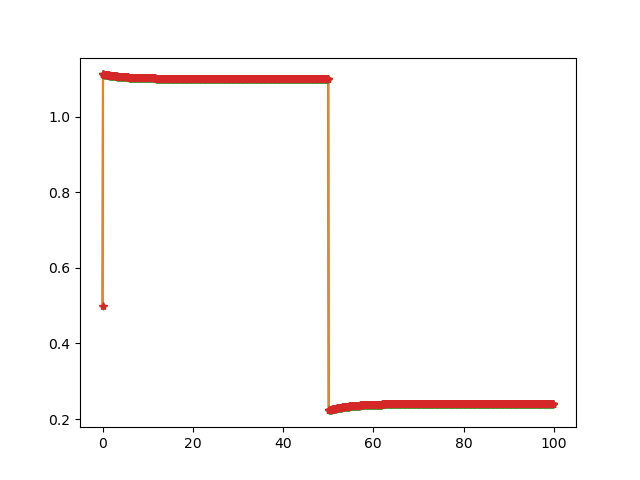

In [8]:
t_max   = 100   #s
dt      = 0.1   #s
nt = int(t_max//dt)
t_vec = np.arange(0,nt+1,1)*dt


PV_vec_ise = np.full_like(t_vec,PV_0)
PV_vec_iae = np.full_like(t_vec,PV_0)
PV_vec_itse = np.full_like(t_vec,PV_0)
PV_vec_itae = np.full_like(t_vec,PV_0)

c_ise = PI_controller_class(SP_0,Kp_ise,Ti_ise,timestep = 0.1)
c_iae = PI_controller_class(SP_0,Kp_iae,Ti_iae,timestep = 0.1)
c_itse = PI_controller_class(SP_0,Kp_itse,Ti_itse,timestep = 0.1)
c_itae = PI_controller_class(SP_0,Kp_itae,Ti_itae,timestep = 0.1)


for i in range(1,nt+1):
    c_ise.calculate_error(PV_vec_ise[i-1])
    c_iae.calculate_error(PV_vec_iae[i-1])
    c_itse.calculate_error(PV_vec_itse[i-1])
    c_itae.calculate_error(PV_vec_itae[i-1])

    if i == 500:
        c_ise.SP = SP_1
        c_iae.SP = SP_1
        c_itse.SP = SP_1
        c_itae.SP = SP_1

    PV_vec_ise[i] = PV_vec_ise[i-1]+c_ise.get_control_variable()
    PV_vec_iae[i] = PV_vec_iae[i-1]+c_iae.get_control_variable()
    PV_vec_itse[i] = PV_vec_itse[i-1]+c_itse.get_control_variable()
    PV_vec_itae[i] = PV_vec_itae[i-1]+c_itae.get_control_variable()

fig5 = plt.figure()
plt.plot(t_vec,PV_vec_ise,label='ise')
plt.plot(t_vec,PV_vec_iae,'.-',label='iae')
plt.plot(t_vec,PV_vec_itse,'+',label='itse')
plt.plot(t_vec,PV_vec_itae,'*',label='itae')